# Sentiment Analysis

In [ ]:
import numpy as np
import pandas as pd
import string 

In [ ]:
data = pd.read_excel('drugs.xlsx')
print("The Shape of the Dataset :", data.shape)

The Shape of the Dataset : (20423, 9)


In [ ]:
data.head()

,class,drugName,username,duration,date,condition,review,rating,usefulCount
0,Selective serotonin re-uptake inhibitors,lexapro,Vnica,Taken for 6 months to 1 year,"April 4, 2022",Depression,"“I have previously been on Celexa, Wellbutrin ...",10.0,0
1,Selective serotonin re-uptake inhibitors,lexapro,leelou92,NaN,"April 3, 2022",Generalized Anxiety Disorder,“I said I would come back in a few weeks. It’s...,NaN,3
2,Selective serotonin re-uptake inhibitors,lexapro,19 year old,Taken for 1 to 2 years,"March 21, 2022",Anxiety,“Lexapro has been extremely helpful and change...,10.0,2
3,Selective serotonin re-uptake inhibitors,lexapro,Whitney,Taken for 6 months to 1 year,"March 17, 2022",Anxiety,“I have been taking Lexapro for about 8 months...,10.0,1
4,Selective serotonin re-uptake inhibitors,lexapro,Tried and True,Taken for 10 years or more,"March 16, 2022",Generalized Anxiety Disorder,“I begin taking this drug 10 years ago when I ...,10.0,18


In [ ]:
# check for Missing Values
data.isnull().sum()

class             0
drugName          0
username          0
duration       8950
date              0
condition       181
review            0
rating         1265
usefulCount       0
dtype: int64

In [ ]:
# delete all the records where Condition or rating is Missing
data = data.dropna()

# lets check the Missing values now
data.isnull().sum().sum()

0

In [ ]:
data.shape

(10683, 9)

## Data Preprocessing

#### Removing punctuations

In [ ]:
# First remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

data['review'] = data['review'].apply(punctuation_removal)

In [ ]:
## remove special symbol
def rm_sym(df):
    df['review'] = df['review'].str.replace("&#039;",'\'')
    df['review'].head()
    return df
data = rm_sym(data)

#### Tokenization

In [ ]:
import re
def tokenize(text):
    split=re.split("\W+",text)
    split=split[1:-1]
    return split
data['review_list']=data['review'].apply(lambda x: tokenize(x.lower()))
data['review_list'].head()

0    [i, have, previously, been, on, celexa, wellbu...
2    [lexapro, has, been, extremely, helpful, and, ...
3    [i, have, been, taking, lexapro, for, about, 8...
4    [i, begin, taking, this, drug, 10, years, ago,...
5    [i, have, suffered, with, anxiety, for, most, ...
Name: review_list, dtype: object

#### Removing stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
data['review']=data['review_list'].apply(lambda x: drop_numbers(x))

In [ ]:
data['review_list']=data['review'].apply(lambda x: tokenize(x))

In [ ]:
import nltk
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

data['review_list'] = data['review_list'].apply(lambda x: remove_stopwords(x))
data['review_list'].head()

0    [previously, celexa, wellbutrin, effexor, cele...
2    [extremely, helpful, changed, life, experience...
3    [taking, lexapro, months, side, effects, exper...
4    [begin, taking, drug, years, ago, thought, ser...
5    [suffered, anxiety, life, stopped, driving, go...
Name: review_list, dtype: object

#### Stemming

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = SnowballStemmer('english')
data['review_list'] = data['review_list'].apply(lambda x: stem_tokens(x, stemmer=stemmer))
data['review_list'].head()

0    [previous, celexa, wellbutrin, effexor, celexa...
2    [extrem, help, chang, life, experi, anxieti, d...
3    [take, lexapro, month, side, effect, experienc...
4    [begin, take, drug, year, ago, thought, seriou...
5    [suffer, anxieti, life, stop, drive, go, place...
Name: review_list, dtype: object

## Vectorization

In this part, I use three methods to convert text to vectors: TF-IDF, Wrod2Vec and BERT.

I will integrate these three methods with various machine learning models to see which combination gives the best result.

In [ ]:
# transform the ratings to three categories: positive, neutral and negative
def transform_rating(df):
    df['sentiment'] = ''
    df.loc[df['rating'] >= 7,'sentiment'] = 'positive'
    df.loc[df['rating'] <= 4,'sentiment'] = 'negative'
    df.loc[(df['rating'] > 4) & (df['rating'] < 7),'sentiment'] = 'neutral'
    return df
data = transform_rating(data)

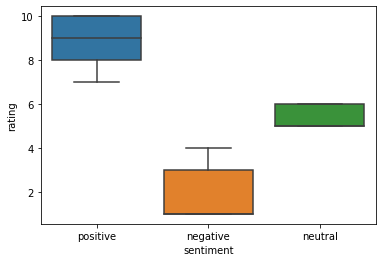

In [ ]:
import seaborn as sns
sns.boxplot(x=data['sentiment'],y=data['rating'])

In [ ]:
# split the dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.25)

### Bag-of-Words

Bag-of-Words

The Bag-of-Words model is simple: it builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. To put it another way, each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (a “bag of words”).

In [ ]:
## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [ ]:
## Generate table of words with their counts
## TfidfVectorizer transform train and test
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import feature_extraction

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
## Generate table of words with their counts
## BoW transform train and test
con_vec_bow = CountVectorizer(max_features = 10000, stop_words='english',tokenizer=tokenize, ngram_range = (1, 3))
X_train_bow = con_vec_bow.fit_transform(train['review'])
y_train = train['sentiment']
X_test_bow = con_vec_bow.transform(test['review'])
y_test = test['sentiment']

print(X_train_bow.shape)
print(X_test_bow.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


(8012, 10000)
(2671, 10000)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf_bow = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_bow.fit(X_train_bow, y_train)
y_predicted_bow = clf_bow.predict(X_test_bow)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 14 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.7s finished


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [ ]:
accuracy_bow, precision_bow, recall_bow, f1_bow= get_metrics(y_test, y_predicted_bow)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_bow, precision_bow, 
                                                                       recall_bow, f1_bow))

accuracy = 0.775, precision = 0.770, recall = 0.775, f1 = 0.772


In [ ]:
predicted = y_predicted_bow
predicted_prob = clf_bow.predict_proba(X_test_bow)

Accuracy: 0.77
Auc: 0.84
Detail:
              precision    recall  f1-score   support

    negative       0.73      0.78      0.75       812
     neutral       0.35      0.29      0.32       249
    positive       0.86      0.85      0.85      1610

    accuracy                           0.77      2671
   macro avg       0.64      0.64      0.64      2671
weighted avg       0.77      0.77      0.77      2671



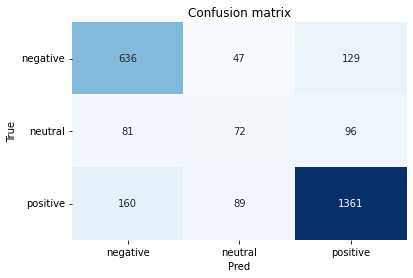

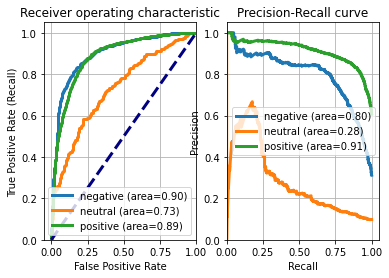

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### TF-IDF

Terms frequency is not necessarily the best representation for text. In fact, you can find in the corpus common words with the highest frequency but little predictive power over the target variable. To address this problem there is an advanced variant of the Bag-of-Words that, instead of simple counting, uses the term frequency–inverse document frequency (or Tf–Idf). Basically, the value of a word increases proportionally to count, but it is inversely proportional to the frequency of the word in the corpus.

In [ ]:
## Generate table of words with their counts
## TfidfVectorizer transform train and test
con_vec_tf = TfidfVectorizer(max_features = 10000, stop_words='english',tokenizer=tokenize, ngram_range = (1, 3))
X_train_tf = con_vec_tf.fit_transform(train['review'])
y_train = train['sentiment']
X_test_tf = con_vec_tf.transform(test['review'])
y_test = test['sentiment']

print(X_train_tf.shape)
print(X_test_tf.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


(8012, 10000)
(2671, 10000)


In [ ]:
from sklearn.linear_model import LogisticRegression

clf_tf = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_tf.fit(X_train_tf, y_train)
y_predicted_tf = clf_tf.predict(X_test_tf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 92 epochs took 1 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


In [ ]:
accuracy_tf, precision_tf, recall_tf, f1_tf = get_metrics(y_test, y_predicted_tf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tf, precision_tf, 
                                                                       recall_tf, f1_tf))

accuracy = 0.775, precision = 0.772, recall = 0.775, f1 = 0.773


In [ ]:
predicted = y_predicted_tf
predicted_prob = clf_tf.predict_proba(X_test_tf)

Accuracy: 0.78
Auc: 0.85
Detail:
              precision    recall  f1-score   support

    negative       0.73      0.78      0.75       812
     neutral       0.35      0.31      0.32       249
    positive       0.86      0.85      0.85      1610

    accuracy                           0.78      2671
   macro avg       0.65      0.64      0.64      2671
weighted avg       0.77      0.78      0.77      2671



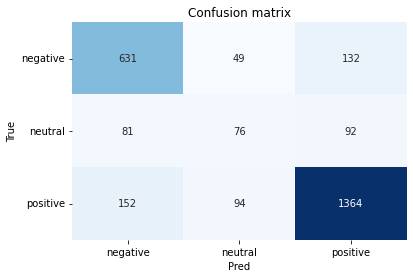

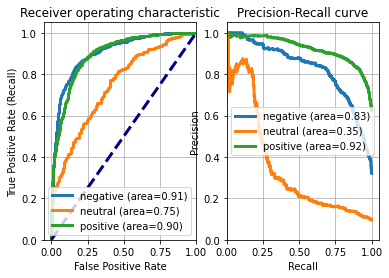

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Word2Vec

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for a classifier, is to average word2vec scores of all words in each sentence.

In Python, you can load a pre-trained Word Embedding model from genism-data.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id': "0B7XkCwpI5KDYNlNUTTlSS21pQmM"})
downloaded.GetContentFile("GoogleNews-vectors-negative300.bin.gz")

In [ ]:
import gensim
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# calculate the average word2vec scores for all the words in each sentence
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, list_review, generate_missing=False):
    embeddings = list_review.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
rev_train = train['review_list']
rev_test = test['review_list']

In [ ]:
rev_train

2478     [major, depress, disord, social, anxieti, post...
16447    [still, use, pill, nausea, lucid, dream, night...
9654     [take, mg, began, littl, effect, feel, anxious...
7199     [medic, instead, help, made, mean, took, day, ...
12994    [suffer, major, depress, past, year, caus, sev...
                               ...                        
7055     [start, mgs, day, stop, day, felt, nauseous, i...
14496    [manag, go, ten, year, without, take, anyth, r...
6233     [doctor, put, celexa, start, tension, headach,...
7173     [mg, imipramin, year, work, switch, cymbalta, ...
19088    [perman, ruin, life, tri, week, decemb, shiver...
Name: review_list, Length: 8012, dtype: object

In [ ]:
X_train_w2v = get_word2vec_embeddings(word2vec, rev_train)
X_test_w2v = get_word2vec_embeddings(word2vec, rev_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_w2v.fit(X_train_w2v, y_train)
y_predicted_word2vec = clf_w2v.predict(X_test_w2v)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 292 epochs took 14 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.4s finished


In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.338, precision = 0.450, recall = 0.338, f1 = 0.369


Apart from using a pre-trained model, I can also fit my own Word2Vec on the training data corpus with gensim. 

Before fitting the model, the review needs to be transformed into a list of lists of n-grams. In this particular case, I’ll try to capture unigrams, bigrams, and trigrams.

In [ ]:
train['review_list']

2478     [major, depress, disord, social, anxieti, post...
16447    [still, use, pill, nausea, lucid, dream, night...
9654     [take, mg, began, littl, effect, feel, anxious...
7199     [medic, instead, help, made, mean, took, day, ...
12994    [suffer, major, depress, past, year, caus, sev...
                               ...                        
7055     [start, mgs, day, stop, day, felt, nauseous, i...
14496    [manag, go, ten, year, without, take, anyth, r...
6233     [doctor, put, celexa, start, tension, headach,...
7173     [mg, imipramin, year, work, switch, cymbalta, ...
19088    [perman, ruin, life, tri, week, decemb, shiver...
Name: review_list, Length: 8012, dtype: object

In [ ]:
## create list of lists of unigrams
lst_rev = []
for string in train['review_list']:
   #lst_words = string.split()
   lst_grams = [" ".join(string[i:i+1]) 
               for i in range(0, len(string), 1)]
   lst_rev.append(lst_grams)


In [ ]:
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_rev, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_rev], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
## fit w2v
word2vec = gensim.models.word2vec.Word2Vec(lst_rev, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [ ]:
def get_word2vec_embeddings(vectors, list_review, generate_missing=False, k=300):
    embeddings = list_review.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [ ]:
X_train_w2v = get_word2vec_embeddings(word2vec, rev_train)
X_test_w2v = get_word2vec_embeddings(word2vec, rev_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_w2v.fit(X_train_w2v, y_train)
y_predicted_word2vec = clf_w2v.predict(X_test_w2v)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 53 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   53.1s finished


In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.350, precision = 0.455, recall = 0.350, f1 = 0.377


In [ ]:
predicted = y_predicted_word2vec
predicted_prob = clf_w2v.predict_proba(X_test_w2v)

In [ ]:
y_predicted_word2vec

array(['neutral', 'positive', 'negative', ..., 'neutral', 'neutral',
       'negative'], dtype=object)

Accuracy: 0.35
Auc: 0.49
Detail:
              precision    recall  f1-score   support

    negative       0.30      0.40      0.34       812
     neutral       0.10      0.26      0.14       249
    positive       0.59      0.34      0.43      1610

    accuracy                           0.35      2671
   macro avg       0.33      0.33      0.31      2671
weighted avg       0.45      0.35      0.38      2671



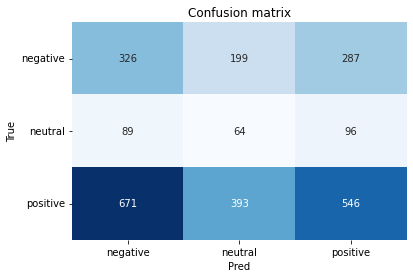

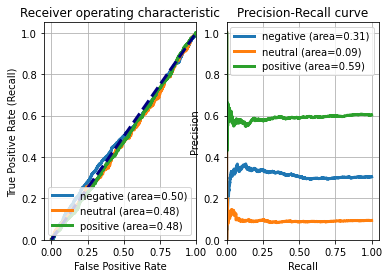

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

It seems that both pretrained and self-trained word2vec model doesn't work well with sentiment classification (at least with logistic regression). I will try another method Doc2Vec instead to see if it gives a better result.

### Doc2Vec

In [ ]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
train["review_list"]

2478     [major, depress, disord, social, anxieti, post...
16447    [still, use, pill, nausea, lucid, dream, night...
9654     [take, mg, began, littl, effect, feel, anxious...
7199     [medic, instead, help, made, mean, took, day, ...
12994    [suffer, major, depress, past, year, caus, sev...
                               ...                        
7055     [start, mgs, day, stop, day, felt, nauseous, i...
14496    [manag, go, ten, year, without, take, anyth, r...
6233     [doctor, put, celexa, start, tension, headach,...
7173     [mg, imipramin, year, work, switch, cymbalta, ...
19088    [perman, ruin, life, tri, week, decemb, shiver...
Name: review_list, Length: 8012, dtype: object

In [ ]:
test["review_list"]

8570     [mg, day, week, complet, zombi, desir, anyth, ...
20088    [wellbutrin, xl, mg, day, treat, depress, anxi...
15966    [medic, ever, first, week, fine, side, effect,...
10916    [paxil, year, basic, becam, celib, absolut, de...
15752    [week, say, viibryd, lexapro, year, felt, like...
                               ...                        
4625     [happi, sad, actual, even, everyth, kind, like...
9204     [one, week, differ, usual, wake, depress, low,...
18427    [wife, take, week, almost, complet, back, tri,...
10826    [pleas, result, two, week, lot, energi, feel, ...
19085    [okay, first, week, felt, littl, better, wasnt...
Name: review_list, Length: 2671, dtype: object

In [ ]:
train = transform_rating(train)
test = transform_rating(test)

In [ ]:
from gensim.models.doc2vec import TaggedDocument

train_tagged = train.apply(
    lambda r: TaggedDocument(words=r["review_list"], tags=[r['sentiment']]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r["review_list"], tags=[r['sentiment']]), axis=1)

In [ ]:
from gensim.models import Doc2Vec
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 8012/8012 [00:00<00:00, 960108.67it/s]


In [ ]:
from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 8012/8012 [00:00<00:00, 1153970.11it/s]


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5829277424185698
Testing F1 score: 0.4383798303466612


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Distributed Memory (DM)

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 8012/8012 [00:00<00:00, 931034.62it/s]


In [ ]:
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 8012/8012 [00:00<00:00, 2490717.73it/s]


In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5919131411456383
Testing F1 score: 0.6052992191003969


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


According to Gensim doc2vec tutorial on the IMDB sentiment data set, combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) improves performance. We will follow, pairing the models together for evaluation.

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6035192811681018
Testing F1 score: 0.6122801157896894


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
###################################################

## Classification

In this section, I will fit the vectors given by BoW and TF-IDF model to various machine learning models including logistic regression (already did), naive bayes, SVM, decision tree, and ensemble learning models incluing LightGBM and XGBoost, use grid search to fine tune parameters and use several metrics to evaluate model performance.